# Import Libraries

In [1]:
import pandas as pd
import requests

import yfinance as yf
from pandas_datareader import data as pdr

In [2]:
import datetime as dt

In [3]:
pd.options.display.max_columns=1000

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Folder Paths

In [4]:
%run configs.ipynb

<hr>

# Ingest & Transform Data 

## PBT Historical Asset Price

### Ingest from Yahoo Finance API

#### Get Current Date

In [5]:
present_date = dt.datetime.strftime(dt.datetime.now(), '%Y-%m-%d')
present_date

'2022-01-15'

In [6]:
yf.pdr_override()

# download dataframe
data = pdr.get_data_yahoo("PBT", start="1996-01-01", end=present_date)


[*********************100%***********************]  1 of 1 completed


### Transform - Select Columns

In [7]:
#resetting index to make date a column and only taking closing price and date
historical_close = data.reset_index()[['Date', 'Close']]
historical_close.head()
historical_close.to_csv(f"{presentation_data_folder}/pbt_asset_price/pbt asset price.csv", index = False)

,Date,Close
0,1996-01-02,3.125
1,1996-01-03,3.375
2,1996-01-04,3.500
3,1996-01-05,3.500
4,1996-01-08,3.625


<hr>


## Oil Price by Month - Web Scrape
* Source URL: https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=RWTC&f=M

### Ingest from EIA Web Site

In [8]:
oilPricebyMonth = pd.read_html('https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=RWTC&f=M')[4]

### Transform - Drop Null Years and Unpivot with Custom Pandas Melt Function

In [9]:
oilPricebyMonth.dropna(subset = ['Year'], inplace = True)
oilPricebyMonth.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1986.0,22.93,15.46,12.61,12.84,15.38,13.43,11.59,15.10,14.87,14.90,15.22,16.11
1,1987.0,18.65,17.75,18.30,18.68,19.44,20.07,21.34,20.31,19.53,19.86,18.85,17.28
2,1988.0,17.13,16.80,16.20,17.86,17.42,16.53,15.50,15.52,14.54,13.77,14.14,16.38
3,1989.0,18.02,17.94,19.48,21.07,20.12,20.05,19.78,18.58,19.59,20.10,19.86,21.10
5,1990.0,22.86,22.11,20.39,18.43,18.20,16.70,18.45,27.31,33.51,36.04,32.33,27.28


In [10]:
def unpivot_eia_commodity_price_tables(df, col_to_not_pivot, value_name):
    
    #unpivoting month with no associated year columns
    unpivot_df = df.melt(id_vars = col_to_not_pivot) 
    
    #creating date mo-yr column by making year a string, splitting at decimal, and concatenating to month
    #inserting to be first column of dataframe
    unpivot_df.insert(0, \
                      "Date", \
                      unpivot_df['variable'] + " " + \
                      unpivot_df[col_to_not_pivot].apply(lambda x: str(x).split('.')[0])
                     )
    
    #converting string mo-yr to datetime
    unpivot_df["Date"] = unpivot_df['Date'].apply(lambda x: dt.datetime.strptime(x, '%b %Y'))
    
    #cleaning up dataframes by dropping unneeded columns, and sorting by date
    unpivot_df.drop(columns = ['variable', col_to_not_pivot], inplace = True)
    unpivot_df.sort_values(by = "Date", inplace = True)
    unpivot_df.rename(columns = {'value': value_name}, inplace = True)

    
    return unpivot_df

In [11]:
oilPricebyMonth = unpivot_eia_commodity_price_tables(oilPricebyMonth, 'Year', value_name='monthly_oil_price')
oilPricebyMonth.head()

,Date,monthly_oil_price
0,1986-01-01,22.93
36,1986-02-01,15.46
72,1986-03-01,12.61
108,1986-04-01,12.84
144,1986-05-01,15.38


In [12]:
oilPricebyMonth.to_csv(f"{presentation_data_folder}/oil_prices/oil price by month.csv", index = False)

## Gas Price by Month - Web Scrape
* Source Url: https://www.eia.gov/dnav/ng/hist/rngwhhdm.htm

### Ingest from Web

In [13]:
gasPricebyMonth = pd.read_html('https://www.eia.gov/dnav/ng/hist/rngwhhdm.htm')[4]

### Transform - Drop Null Years and Unpivot with Custom Pandas Melt Function

In [14]:
gasPricebyMonth.dropna(subset=["Year"], inplace = True)
gasPricebyMonth.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1997.0,3.45,2.15,1.89,2.03,2.25,2.20,2.19,2.49,2.88,3.07,3.01,2.35
1,1998.0,2.09,2.23,2.24,2.43,2.14,2.17,2.17,1.85,2.02,1.91,2.12,1.72
2,1999.0,1.85,1.77,1.79,2.15,2.26,2.30,2.31,2.80,2.55,2.73,2.37,2.36
4,2000.0,2.42,2.66,2.79,3.04,3.59,4.29,3.99,4.43,5.06,5.02,5.52,8.90
5,2001.0,8.17,5.61,5.23,5.19,4.19,3.72,3.11,2.97,2.19,2.46,2.34,2.30


In [15]:
gasPricebyMonth = unpivot_eia_commodity_price_tables(gasPricebyMonth, 'Year', value_name='monthly_gas_price')
gasPricebyMonth.head()

,Date,monthly_gas_price
0,1997-01-01,3.45
25,1997-02-01,2.15
50,1997-03-01,1.89
75,1997-04-01,2.03
100,1997-05-01,2.25


In [16]:
gasPricebyMonth.to_csv(f"{presentation_data_folder}/gas_prices/gas price by month.csv", index = False)

<hr>
<br>



## Historical Field Production

### Ingest historical production

In [17]:
historical_prod = pd.read_csv(f'{raw_data_folder}/historical_production/Historical Production.csv')

### Transform - Convert String Timestamp to Date and Adding Fields

In [18]:
historical_prod['Date'] = pd.to_datetime(historical_prod['Date'])

historical_prod['Mbbl/month'] = historical_prod['Oil']/1E3
historical_prod['Ten\'s of Thousand bbl /month (1E-4)'] = historical_prod['Oil']/1E4

historical_prod['MMcf/month'] = historical_prod['Gas']/1E3
historical_prod['Ten\'s of Thousand mcf /month (1E-4)'] = historical_prod['Gas']/1E4

In [19]:
historical_prod.to_csv(f'{presentation_data_folder}/historical_production/historical_production.csv', index = False)

<hr>
<br>

## Wells in Field

### Ingest Wells

In [20]:
wells = pd.read_csv(f'{raw_data_folder}/wells/Production Table.csv')

In [21]:
import re

In [22]:
chars_split_regex = ', | . | '

In [23]:
testname = wells["Well/Lease Name"].iloc[0]

re.split(chars_split_regex, testname)

['WADDELL', 'TR', 'B']

In [24]:
wells["Well/Lease Name"].apply(lambda x: re.split(chars_split_regex,str(x))[0]).value_counts()


WADDELL              546
MCKNIGHT              49
6                     20
LANDLUBBER            13
YELLOW                 9
STEDE                  5
CROLEY                 4
JEAN                   3
WADDELL,W.N.,ETAL      3
MCCAMEY                3
M.B.                   3
CLEW                   3
nan                    3
BLACK                  2
BARATARIA              2
GALLEON                1
RAYDEN                 1
ROADRUNNER             1
W.                     1
Name: Well/Lease Name, dtype: int64

### Transform - Add Fields

In [25]:
wells["Total MMbbl"] = wells['Cum Oil']/1E6
wells["Total BCF"] = wells['Cum Gas']/1E6

In [26]:
wells.to_csv(f'{presentation_data_folder}/wells/wells.csv', index = False)

<hr>
<br>

## Permits

### Ingest Permits

In [27]:
permits = pd.read_csv(f'{raw_data_folder}/permits/Permits Table.csv')

### Transform - Group Similar Values in Well Status Field

In [28]:
def group_categories(value, similar_categories, target_category):
    '''
    similar_categories: list of values that wish to be grouped together
    target_category: value for similar values to be grouped to
    value: value in row of DataFrame
    '''
    if value in similar_categories:
        return target_category
    else:
        return value

In [29]:
permits['Well Status'].value_counts()

PERMITTED    77
DUC          53
ACTIVE       34
COMPLETED    12
UNKNOWN      11
CANCELLED     3
DRILLING      2
INACTIVE      2
DRILLED       1
P & A         1
Name: Well Status, dtype: int64

In [30]:
vals_to_be_grouped = ['DUC', 'COMPLETED', 'INACTIVE', 'DRILLED']

In [31]:
permits['Well Status Grouped'] = permits['Well Status'].apply(lambda x: group_categories(x, vals_to_be_grouped, 'Drilled, Not Producing'))

In [32]:
permits['Well Status Grouped'].value_counts()

PERMITTED                 77
Drilled, Not Producing    68
ACTIVE                    34
UNKNOWN                   11
CANCELLED                  3
DRILLING                   2
P & A                      1
Name: Well Status Grouped, dtype: int64

In [33]:
permits.to_excel(f'{presentation_data_folder}/permits/permits.xlsx', index = False)

<hr>
<br>

# Combined Tables for Analysis

## Gross Revenue 

In [34]:
historical_prod.head(1)
oilPricebyMonth.head(1)
gasPricebyMonth.head(1)

,Date,Oil,Gas,Water,Well Count,Mbbl/month,Ten's of Thousand bbl /month (1E-4),MMcf/month,Ten's of Thousand mcf /month (1E-4)
0,1941-01-01,4684,0,16736,1,4.684,0.4684,0.0,0.0


,Date,monthly_oil_price
0,1986-01-01,22.93


,Date,monthly_gas_price
0,1997-01-01,3.45


### Transform - Create Field for Joining Tables

In [35]:
#creating field for joining 3 tables since dates resembling each month differ slightly
historical_prod['Date Key'] = historical_prod['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))
gasPricebyMonth['Date Key'] = gasPricebyMonth['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))
oilPricebyMonth['Date Key'] = oilPricebyMonth['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))

In [36]:
historical_prod.head(2)
oilPricebyMonth.head(2)
gasPricebyMonth.head(2)

,Date,Oil,Gas,Water,Well Count,Mbbl/month,Ten's of Thousand bbl /month (1E-4),MMcf/month,Ten's of Thousand mcf /month (1E-4),Date Key
0,1941-01-01,4684,0,16736,1,4.684,0.4684,0.0,0.0,1941-01
1,1941-02-01,5458,0,19502,1,5.458,0.5458,0.0,0.0,1941-02


,Date,monthly_oil_price,Date Key
0,1986-01-01,22.93,1986-01
36,1986-02-01,15.46,1986-02


,Date,monthly_gas_price,Date Key
0,1997-01-01,3.45,1997-01
25,1997-02-01,2.15,1997-02


### Perform Join and Clean Up Fields

In [37]:
#merging 3 tables together to get commodity pricing along side production. Then cleaning up by selecting only necessary columns
revenue = pd.merge(historical_prod, oilPricebyMonth.drop(columns = 'Date'), on = 'Date Key', how = 'inner') \
    .merge(gasPricebyMonth.drop(columns = 'Date'), on = 'Date Key', how = 'inner') \
    .drop(columns = 'Date Key') \
    .loc[:,['Date', 'Oil', 'Gas', 'monthly_oil_price', 'monthly_gas_price']]

### Calculate Revenue for Oil, Gas, and Total

In [38]:
revenue["Revenue Oil"] = revenue["Oil"] * revenue['monthly_oil_price']
revenue["Revenue Gas"] = revenue["Gas"] * revenue['monthly_gas_price']

revenue['Total Revenue'] = revenue["Revenue Oil"] + revenue["Revenue Gas"]

revenue['$M Total Revenue'] = round(revenue["Total Revenue"] / 1E6, 2)

revenue

,Date,Oil,Gas,monthly_oil_price,monthly_gas_price,Revenue Oil,Revenue Gas,Total Revenue,$M Total Revenue
0,1997-01-01,280995,1202974,25.13,3.45,7061404.35,4150260.30,11211664.65,11.21
1,1997-02-01,260744,1161835,22.18,2.15,5783301.92,2497945.25,8281247.17,8.28
2,1997-03-01,290928,1284172,20.97,1.89,6100760.16,2427085.08,8527845.24,8.53
3,1997-04-01,286429,1232001,19.70,2.03,5642651.30,2500962.03,8143613.33,8.14
4,1997-05-01,310124,1289414,20.82,2.25,6456781.68,2901181.50,9357963.18,9.36
...,...,...,...,...,...,...,...,...,...
293,2021-06-01,200332,914030,71.38,3.26,14299698.16,2979737.80,17279435.96,17.28
294,2021-07-01,220864,1002275,72.49,3.84,16010431.36,3848736.00,19859167.36,19.86
295,2021-08-01,206105,1023171,67.73,4.07,13959491.65,4164305.97,18123797.62,18.12
296,2021-09-01,203026,973874,71.65,5.16,14546812.90,5025189.84,19572002.74,19.57


In [39]:
revenue.to_csv(f'{presentation_data_folder}/revenue/revenue.csv', index = False)

## Creating Normalized / Scaled Revenue and Asset Price -  from 0 to 1

In [40]:
from sklearn import preprocessing

### Scaling Revenue

In [41]:
scalerRev = preprocessing.MinMaxScaler().fit(revenue.iloc[:,1:])

In [42]:
scaled_revenue_vals = scalerRev.transform(revenue.iloc[:,1:])

In [43]:
scaled_Revenue = pd.DataFrame(scaled_revenue_vals)
scaled_Revenue.insert(0, 'Date', revenue['Date'])
scaled_Revenue.columns = revenue.columns
scaled_Revenue

,Date,Oil,Gas,monthly_oil_price,monthly_gas_price,Revenue Oil,Revenue Gas,Total Revenue,$M Total Revenue
0,1997-01-01,0.722649,0.845847,0.112462,0.154368,0.233823,0.259824,0.244986,0.244840
1,1997-02-01,0.634258,0.790250,0.088387,0.044105,0.155704,0.109146,0.126395,0.126265
2,1997-03-01,0.766005,0.955581,0.078511,0.022053,0.175108,0.102684,0.136374,0.136382
3,1997-04-01,0.746367,0.885075,0.068147,0.033927,0.147108,0.109421,0.120825,0.120599
4,1997-05-01,0.849791,0.962665,0.077287,0.052587,0.196868,0.145918,0.169968,0.169972
...,...,...,...,...,...,...,...,...,...
293,2021-06-01,0.370574,0.455358,0.489921,0.138253,0.676233,0.153081,0.490545,0.490490
294,2021-07-01,0.460191,0.574615,0.498980,0.187447,0.780795,0.232327,0.594945,0.594901
295,2021-08-01,0.395771,0.602855,0.460132,0.206955,0.655440,0.261105,0.524716,0.524484
296,2021-09-01,0.382332,0.536233,0.492124,0.299406,0.691337,0.339611,0.583323,0.583165


In [44]:
for column in scaled_Revenue.columns[1:]:
    scaled_Revenue.rename(columns = {column: f'scaled_{column}'}, inplace=True)

In [45]:
scaled_Revenue.head(2)
scaled_Revenue.to_csv(f'{presentation_data_folder}/scaled_transforms/scaled_revenue_and_commodity.csv', index = False)

,Date,scaled_Oil,scaled_Gas,scaled_monthly_oil_price,scaled_monthly_gas_price,scaled_Revenue Oil,scaled_Revenue Gas,scaled_Total Revenue,scaled_$M Total Revenue
0,1997-01-01,0.722649,0.845847,0.112462,0.154368,0.233823,0.259824,0.244986,0.244840
1,1997-02-01,0.634258,0.790250,0.088387,0.044105,0.155704,0.109146,0.126395,0.126265


### Scaling Asset Price

In [46]:
scalerRev = preprocessing.MinMaxScaler().fit(historical_close.iloc[:,1:])

scaled_historical_close_vals = scalerRev.transform(historical_close.iloc[:,1:])

scaled_historical_close = pd.DataFrame(scaled_historical_close_vals)
scaled_historical_close.insert(0, 'Date', historical_close['Date'])
scaled_historical_close.columns = historical_close.columns
scaled_historical_close.head(2)

,Date,Close
0,1996-01-02,0.036942
1,1996-01-03,0.046819


#### Rename cols to Scaled 'x'

In [47]:
for column in scaled_historical_close.columns[1:]:
    scaled_historical_close.rename(columns = {column: f'scaled_{column}'}, inplace=True)

In [48]:
scaled_historical_close.head(2)
scaled_historical_close.to_csv(f'{presentation_data_folder}/scaled_transforms/scaled_asset_price.csv', index = False)

,Date,scaled_Close
0,1996-01-02,0.036942
1,1996-01-03,0.046819


In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, 'Revenue ($M) vs Year')

/Users/Mishaun_Bhakta/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Revenue ($M) vs Year'}, xlabel='Date', ylabel='$M Total Revenue'>

/Users/Mishaun_Bhakta/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Revenue ($M) vs Year'}, xlabel='Date', ylabel='$M Total Revenue'>

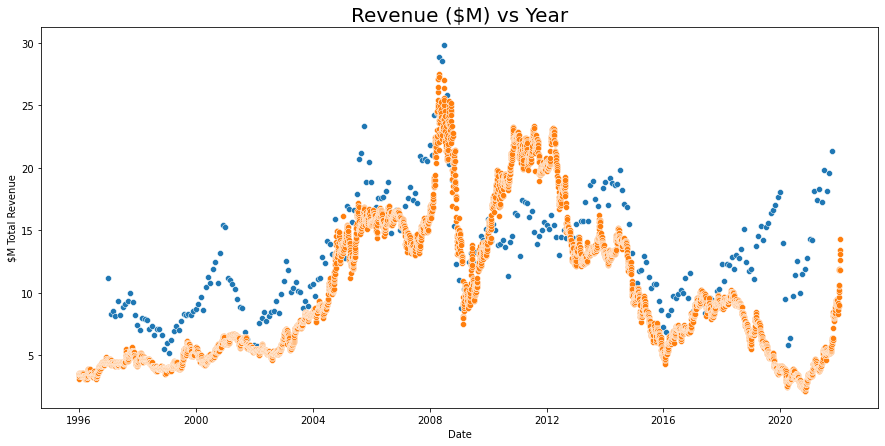

In [50]:
plt.figure(figsize=(15,7))

plt.title('Revenue ($M) vs Year', fontdict={"fontsize": 20})
sns.scatterplot(revenue['Date'], revenue['$M Total Revenue'], palette='rainbow')
sns.scatterplot(historical_close["Date"], historical_close['Close'])